In [4]:
# Tensorflow/Keras
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
#from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from keras.utils import to_categorical
#from keras.utils import to_categorical
#from classification_models_3D.tfkeras import Classifiers

2.4.0


Using TensorFlow backend.


In [5]:
print(keras.__version__)
print(tf.__version__)

2.4.0
2.4.0


In [6]:
import os
import h5py
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from tensorflow import keras
#from keras import backend as K
#from classification_models_3D.tfkeras import Classifiers
from tensorflow.keras.optimizers import Adam

In [7]:
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
os.chdir(DIR)
print(os.getcwd())

/tf/notebooks/schnemau/xAI_stroke_3d


In [8]:
IMG_DIR = "/tf/notebooks/hezo/stroke_perfusion/data/"
OUTPUT_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/"
path_img = IMG_DIR + 'dicom_2d_192x192x3_clean_interpolated_18_02_2021_preprocessed2.h5'
path_tab = IMG_DIR + 'baseline_data_zurich_prepared.csv'

In [9]:
# should only non TIA (transient ischemic attack) patients be included?
only_non_tia = False

with h5py.File(path_img, "r") as h5:
    X_in = h5["X"][:]
    Y_img = h5["Y_img"][:]
    Y_pat = h5["Y_pat"][:]
    pat = h5["pat"][:]

X_in = np.expand_dims(X_in, axis = 4)

print("image shape in: ", X_in.shape)
print("image min, max, mean, std: ", X_in.min(), X_in.max(), X_in.mean(), X_in.std())


## read tabular data
dat = pd.read_csv(path_tab, sep=",")

print("tabular shape in: ", dat.shape)

image shape in:  (439, 128, 128, 28, 1)
image min, max, mean, std:  -0.7314910890799393 26.423200798592248 -4.100563400421584e-18 1.0
tabular shape in:  (507, 16)


In [10]:
# get original data
n = []
for p in pat:
    if p in dat.p_id.values:
        n.append(p)
n = len(n)

# match image and tabular data
X = np.zeros((n, X_in.shape[1], X_in.shape[2], X_in.shape[3], 3)) #hardcoding for resnet50
X_tab = np.zeros((n, 13))
Y_mrs = np.zeros((n))
Y_eventtia = np.zeros((n))
p_id = np.zeros((n))

i = 0
for j, p in enumerate(pat):
    if p in dat.p_id.values:
        k = np.where(dat.p_id.values == p)[0]
        X_tab[i,:] = dat.loc[k,["age", "sexm", "nihss_baseline", "mrs_before",
                               "stroke_beforey", "tia_beforey", "ich_beforey", 
                               "rf_hypertoniay", "rf_diabetesy", "rf_hypercholesterolemiay", 
                               "rf_smokery", "rf_atrial_fibrillationy", "rf_chdy"]]
        X[i] = X_in[j]
        p_id[i] = pat[j]
        Y_eventtia[i] = Y_pat[j]
        Y_mrs[i] = dat.loc[k, "mrs3"]
        i += 1
p_id = p_id.astype("int")

X[:,:,:,:,1] = X[:,:,:,:,0] #hardcoding for resnet50 adjustment (grayscale vs. colour)
X[:,:,:,:,2] = X[:,:,:,:,0]
        
print("X img out shape: ", X.shape)
print("X tab out shape: ", X_tab.shape)
print("Y mrs out shape: ", Y_mrs.shape)

X img out shape:  (407, 128, 128, 28, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)


In [11]:
## all mrs <= 2 are favorable all higher unfavorable
Y_new = []
for element in Y_mrs:
    if element in [0,1,2]:
        Y_new.append(0)
    else:
        Y_new.append(1)
Y_new = np.array(Y_new)

In [12]:
p_idx = np.arange(0, len(p_id))+1
# Safe ids in pd
id_tab = pd.DataFrame(
    {"p_idx": p_idx,
     "p_id": p_id,
     "mrs": Y_mrs,
     "unfavorable": Y_new
    }
)
id_tab

,p_idx,p_id,mrs,unfavorable
0,1,1,1.0,0
1,2,2,1.0,0
2,3,3,0.0,0
3,4,5,0.0,0
4,5,6,3.0,1
...,...,...,...,...
402,403,555,0.0,0
403,404,556,0.0,0
404,405,557,1.0,0
405,406,559,1.0,0


In [13]:
# Own functions
from functions.plot_slices import plot_slices
# ontram functions
from k_ontram_functions.ontram import ontram
from k_ontram_functions.ontram_loss import ontram_loss
from k_ontram_functions.ontram_metrics import ontram_acc, ontram_auc
from k_ontram_functions.ontram_predict import predict_ontram, get_parameters
from functions.augmentation3d import zoom, rotate, flip, shift

In [14]:
# Model for the intercept function: C = number of classes
def mod_baseline(C):
    mod = keras.Sequential(name = "mod_baseline")
    mod.add(keras.Input(shape = (1, )))
    mod.add(keras.layers.Dense(C - 1, activation = "linear", use_bias = False))
    return mod

# Model for linear shift terms
def mod_linear_shift(x):
    mod = keras.Sequential(name = "mod_linear_shift")
    mod.add(keras.Input(shape = (x, )))
    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
    return mod

# Model for complex shift terms
#def mod_complex_shift(x):
#    mod = keras.Sequential(name = "mod_complex_shift")
#    mod.add(keras.Input(shape = (x, )))
#    mod.add(keras.layers.Dense(8, activation = "relu"))
#    mod.add(keras.layers.Dense(8, activation = "relu"))
#    mod.add(keras.layers.Dense(1, activation = "linear", use_bias = False))
#    return mod  

In [15]:
# ResNet with pretrained weights
from classification_models_3D.tfkeras import Classifiers

def img_model(nout, last_layer_activation = "linear"):
    ResNet50, preprocess_input = Classifiers.get('resnet50')
    base_model = ResNet50(
        input_shape=(128, 128, 28, 3), #TODO hardcoding for resnet50, parameter for image model.....
        weights='imagenet', 
        include_top = False)

    # add a global average pooling layer and the dense part and define model
    x = base_model.output
    x = keras.layers.GlobalAveragePooling3D()(x)
    x = keras.layers.Dense(128, name="fc1")(x)
    x = keras.layers.Dense(128, name = "fc2")(x)
    x = keras.layers.Dense(nout, name="output")(x)
    predictions = keras.layers.Activation(last_layer_activation, name='output_activation')(x)
    
    return keras.Model(inputs=base_model.input, outputs=predictions)
mod = img_model(1, "linear")
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 28 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 28, 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding3d (ZeroPadding3D)  (None, 134, 134, 34, 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv3D)                  (None, 64, 64, 14, 6 65856       zero_padding3d[0][0]             
____________________________________________________________________________________________

# Simple intercept, Complex shift, Linear shift


In [16]:
Y_mrs = Y_new

In [23]:
print("X img out shape: ", X.shape)
print("X tab out shape: ", X_tab.shape)
print("Y mrs out shape: ", Y_mrs.shape)
print("Y mrs out shape: ", Y_new.shape)

X img out shape:  (407, 128, 128, 28, 3)
X tab out shape:  (407, 13)
Y mrs out shape:  (407,)
Y mrs out shape:  (407,)


In [24]:
# split train validation test
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(range(X.shape[0]), train_size = int(X.shape[0]*0.8), random_state = 20)
train_idx, valid_idx = train_test_split(range(len(train_idx)), train_size = int(len(train_idx)*0.8), random_state = 20)

X_train = X[train_idx]
X_valid = X[valid_idx]
X_test = X[test_idx]

X_tab_train = X_tab[train_idx]
X_tab_valid = X_tab[valid_idx]
X_tab_test = X_tab[test_idx]

Y_img_train = Y_img[train_idx]
Y_img_valid = Y_img[valid_idx]
Y_img_test = Y_img[test_idx]

#Y_pat_train = Y_pat[train_idx]
#Y_pat_valid = Y_pat[valid_idx]
#Y_pat_test = Y_pat[test_idx]

pat_train = p_id[train_idx]
pat_valid = p_id[valid_idx]
pat_test = p_id[test_idx]

Y_mrs_train = Y_mrs[train_idx]
Y_mrs_valid = Y_mrs[valid_idx]
Y_mrs_test = Y_mrs[test_idx]

#print(X_train.shape, X_tab_train.shape, Y_img_train.shape, Y_pat_train.shape, pat_train.shape, Y_mrs_train.shape)
#print(X_valid.shape, X_tab_valid.shape, Y_img_valid.shape, Y_pat_valid.shape, pat_valid.shape, Y_mrs_valid.shape)
#print(X_test.shape, X_tab_test.shape, Y_img_test.shape, Y_pat_test.shape, pat_test.shape, Y_mrs_test.shape)

print(X_train.shape, X_tab_train.shape, Y_img_train.shape, pat_train.shape, Y_mrs_train.shape)
print(X_valid.shape, X_tab_valid.shape, Y_img_valid.shape, pat_valid.shape, Y_mrs_valid.shape)
print(X_test.shape, X_tab_test.shape, Y_img_test.shape, pat_test.shape, Y_mrs_test.shape)


(260, 128, 128, 28, 3) (260, 13) (260, 28) (260,) (260,)
(65, 128, 128, 28, 3) (65, 13) (65, 28) (65,) (65,)
(82, 128, 128, 28, 3) (82, 13) (82, 28) (82,) (82,)


In [25]:
# to categorical (only for the patient label stroke vs. no stroke)
#Y_pat_train = to_categorical(Y_pat_train)
#Y_pat_valid = to_categorical(Y_pat_valid)
#Y_pat_test = to_categorical(Y_pat_test)

Y_mrs_train = to_categorical(Y_mrs_train)
Y_mrs_valid = to_categorical(Y_mrs_valid)
Y_mrs_test = to_categorical(Y_mrs_test)

In [26]:
# function for preprocessing
def train_preprocessing(data, label):
    """Process training data."""
    intercept = data[0] # intercept
    volume = data[1] # shift: image
    tabular = data[2] # shift: tabular
    volume = zoom(volume)
    volume = rotate(volume)
    volume = shift(volume)
    volume = flip(volume)
    return (intercept, volume, tabular), label

In [27]:
# Hyperparameters
batch_size = 4
toplayer_epochs = 40
alllayer_epochs = 40

In [28]:
# Define datasets for ONTRAM 
    
train_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_train),1]), X_train, X_tab_train))
train_labels = tf.data.Dataset.from_tensor_slices((Y_mrs_train))
    
valid_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_valid),1]), X_valid, X_tab_valid))
valid_labels = tf.data.Dataset.from_tensor_slices((Y_mrs_valid))
   
test_data = tf.data.Dataset.from_tensor_slices((np.ones(shape=[len(X_test),1]), X_test, X_tab_test))
test_labels = tf.data.Dataset.from_tensor_slices((Y_mrs_test))
   
train_loader = tf.data.Dataset.zip((train_data, train_labels))
validation_loader = tf.data.Dataset.zip((valid_data, valid_labels))
test_loader = tf.data.Dataset.zip((test_data, test_labels))
    
train_dataset = (train_loader.shuffle(len(X_train))
                    .map(train_preprocessing)
                   .batch(batch_size, drop_remainder = True))
validation_dataset = (validation_loader.batch(batch_size, drop_remainder = True))
test_dataset = (test_loader.batch(len(X_test), drop_remainder = True))


In [20]:
# Hyperparameters for all models
C = 2
mbl = mod_baseline(C)
mls = mod_linear_shift(X_tab.shape[1])  
polr = ontram(mbl, mls)
mcs = img_model(1, "linear")

In [21]:
# start to train the top layers
#freezen & überschreiben für jedes Layer
for layer in mcs.layers:
    layer.trainable = False

model = ontram(polr.mod_baseline, [mcs, polr.mod_shift[0]])

In [22]:
# compile and train
model.compile(
    optimizer=Adam(),  # Use Adam optimizer directly here
    loss=ontram_loss(C, batch_size),
    metrics=[ontram_acc(C, batch_size)]
)

In [23]:
toplayer_epochs = 15
history = model.fit(
    train_dataset,
   validation_data=validation_dataset,
    epochs=toplayer_epochs)

Epoch 1/15
65/65 [==============================] - 113s 2s/step - loss: 0.7875 - acc: 0.6406 - val_loss: 0.5136 - val_acc: 0.7656
Epoch 2/15
65/65 [==============================] - 109s 2s/step - loss: 0.6561 - acc: 0.6838 - val_loss: 0.4895 - val_acc: 0.7656
Epoch 3/15
65/65 [==============================] - 108s 2s/step - loss: 0.6160 - acc: 0.6884 - val_loss: 0.4684 - val_acc: 0.8125
Epoch 4/15
65/65 [==============================] - 108s 2s/step - loss: 0.5513 - acc: 0.7623 - val_loss: 0.4468 - val_acc: 0.8750
Epoch 5/15
65/65 [==============================] - 108s 2s/step - loss: 0.6139 - acc: 0.7482 - val_loss: 0.4290 - val_acc: 0.8750
Epoch 6/15
65/65 [==============================] - 108s 2s/step - loss: 0.4949 - acc: 0.7682 - val_loss: 0.4142 - val_acc: 0.8750
Epoch 7/15
65/65 [==============================] - 108s 2s/step - loss: 0.6009 - acc: 0.7272 - val_loss: 0.3990 - val_acc: 0.8750
Epoch 8/15
65/65 [==============================] - 108s 2s/step - loss: 0.5179 - a

In [24]:
model.save("/tf/notebooks/schnemau/xAI_stroke_3d/model/test2.h5", save_format="tf")

In [25]:
#model.save("/tf/notebooks/schnemau/xAI_stroke_3d/model/test2.h5")
#model.load_weights("/tf/notebooks/schnemau/xAI_stroke_3d/model/test1")
#model = tf.keras.models.load_model("/tf/notebooks/schnemau/xAI_stroke_3d/model/test1")

In [26]:
#history.history

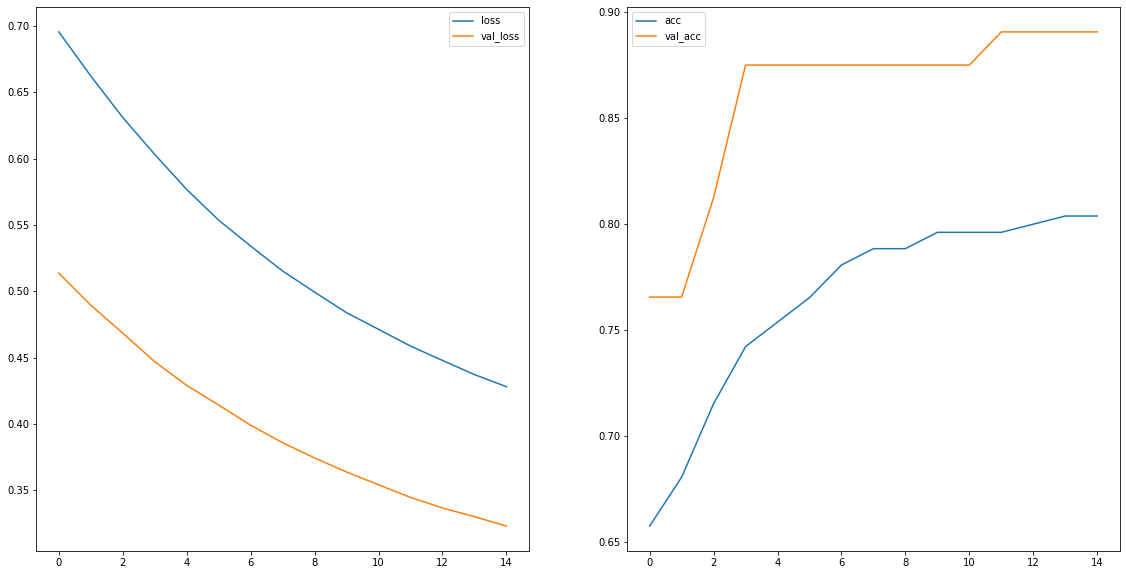

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,10))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'],label = "val_loss")
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history['acc'], label = "acc")
plt.plot(history.history['val_acc'],label = "val_acc")
plt.legend()
plt.show()

In [28]:
preds = predict_ontram(model, data = test_dataset)

In [29]:
results = pd.DataFrame(preds["pdf"])

In [30]:
y_pred_class = preds['pred_class']
y_true_class = np.argmax(Y_mrs_test, axis=1)

In [31]:
results = pd.DataFrame(
    {"y_pred": y_pred_class,
     "y_true": y_true_class,
     "p_id": pat_test
    }
)
results = pd.DataFrame(
    {"y_pred": y_pred_class,
     "y_true": y_true_class,
     "p_id": pat_test,
     "p_idx": results.merge(id_tab, on='p_id', how='left')['p_idx']

    }
)
results

,y_pred,y_true,p_id,p_idx
0,0,0,15,11
1,0,0,376,284
2,0,0,203,149
3,0,0,283,201
4,0,0,62,48
...,...,...,...,...
77,0,0,463,327
78,0,0,59,46
79,0,1,525,381
80,0,0,39,29


In [32]:
results.iloc[[0]]

,y_pred,y_true,p_id,p_idx
0,0,0,15,11
